# Tutorial: Rietveld Method for Neutron Bragg Edge Analysis with nbragg

Tsviki Y. Hirsh

Aug 11th 2025

This notebook provides a step-by-step guide to using the **Rietveld method** for fitting neutron transmission data to analyze material properties, specifically focusing on the `nbragg` package. The Rietveld method is a staged refinement technique commonly used in crystallography to iteratively refine model parameters, improving the fit stability for complex datasets. Here, we apply it to neutron Bragg edge analysis, which is used to study crystalline structures through neutron transmission spectra.

## Prerequisites
- **Python packages**: Ensure you have `nbragg`, `pandas`, `numpy`, `lmfit`, and `matplotlib` installed.
- **Data files**: You'll need neutron transmission data (e.g., `iron_powder.csv`) and open beam data (e.g., `openbeam.csv`).
- **Background**: Basic understanding of neutron scattering and crystallographic fitting is helpful but not required.

## Learning Objectives
By the end of this tutorial, you will:
1. Understand the basics of the Rietveld method for fitting neutron transmission data.
2. Learn how to load and visualize neutron data using the `nbragg` package.
3. Set up and register materials for cross-section calculations.
4. Perform a Rietveld-style staged refinement to fit a transmission model.
5. Visualize and interpret the fitting results.

---

## Step 1: Import the `nbragg` Package

The `nbragg` package provides tools for neutron Bragg edge analysis, including data handling, material registration, cross-section calculations, and model fitting.



In [1]:
import nbragg


---

## Step 2: Load and Visualize Neutron Data

We start by loading neutron transmission data and open beam data. The `nbragg.Data.from_counts` method processes these datasets to compute transmission spectra, which are essential for analyzing Bragg edges.

### Explanation
- **Data file**: Contains neutron counts for the sample (e.g., `iron_powder.csv`).
- **Open beam file**: Contains counts without the sample (e.g., `openbeam.csv`).
- **Parameters**:
  - `L`: Flight path length (in meters).
  - `tstep`: Time step for data binning (in seconds).

### Code


In [2]:
data = nbragg.Data.from_counts(
    "iron_powder.csv",
    "openbeam.csv",
    L=9, tstep=1e-5
)


### Visualize the Data
Plotting the data helps us inspect the transmission spectrum and identify Bragg edges, which appear as sharp changes in transmission due to neutron diffraction by the crystal lattice.



<Axes: xlabel='wavelength [Å]', ylabel='Transmission'>

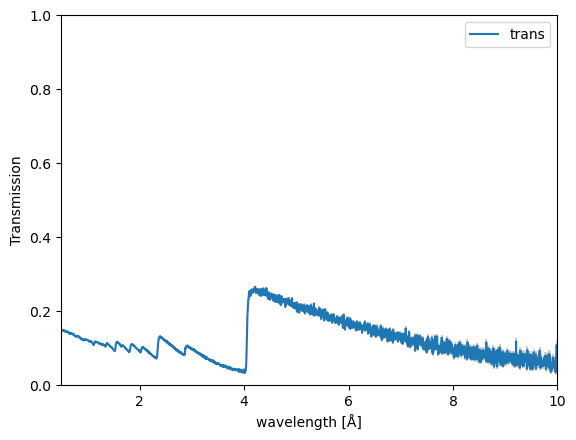

In [3]:
data.plot()


**Expected Output**: A plot showing transmission versus wavelength, with dips indicating Bragg edges characteristic of the material's crystal structure.

---

## Step 3: Register Materials

To model the neutron transmission, we need to define the materials in the sample. The `nbragg` package uses material files (e.g., `.ncmat`) that describe crystallographic properties.

### Explanation
- **Materials**: We register two materials here:
  - **Iron-alpha (Fe)**: A crystalline material with space group 229 (Im-3m), exhibiting Bragg edges.
  - **Cellulose**: An amorphous material contributing to the background scattering.
- **Material files**: These contain crystallographic data, such as lattice parameters and scattering lengths, required for cross-section calculations.

### Code


In [4]:
nbragg.register_material("Fe_sg229_Iron-alpha_CrysExtn1.ncmat")
nbragg.register_material("Cellulose_C6O5H10.ncmat")


---

## Step 4: Define the Cross-Section

The neutron cross-section describes how neutrons interact with the sample. We create a composite cross-section by combining contributions from iron and cellulose, weighted by their volume fractions.

### Explanation
- **CrossSection**: The `nbragg.CrossSection` class computes the total neutron cross-section for a material or mixture.
- **Weighting**: Here, we assume 2.75% cellulose and 97.25% iron-alpha by volume.
- **Visualization**: Plotting the cross-section helps verify the material model before fitting.

### Code


<Axes: xlabel='Wavelength [Å]', ylabel='σ [barn]'>

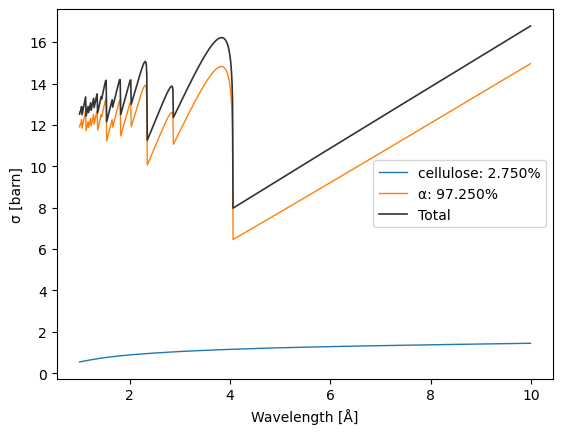

In [5]:
xs = 0.0275 * nbragg.CrossSection(cellulose=nbragg.materials["Cellulose_C6O5H10.ncmat"]) + \
     (1 - 0.0275) * nbragg.CrossSection(α=nbragg.materials["Fe_sg229_Iron-alpha_CrysExtn1.ncmat"])
xs.plot()


**Expected Output**: A plot of the total cross-section versus wavelength, showing Bragg edges from iron and a smoother contribution from cellulose.

---

## Step 5: Set Up the Transmission Model

The `nbragg.TransmissionModel` class creates a model to fit the observed transmission data. We enable refinement of extinction and background parameters to account for complex scattering effects.

### Explanation
- **Extinction**: Accounts for deviations from ideal scattering due to crystal imperfections (enabled with `vary_extinction=True`).
- **Background**: Models non-crystalline scattering contributions (enabled with `vary_background=True`).
- **Parameters**: The model includes parameters like `norm` (normalization), `thickness`, `background`, and `extinction`, which can be inspected with `model.params`.

### Code


In [6]:
model = nbragg.TransmissionModel(xs, vary_extinction=True, vary_background=True)
model.params

/opt/conda/lib/python3.13/site-packages/nbragg/models.py:1878: UserWarning: @CRYSEXTN section is not defined for the cellulose phase
  warnings.warn(f"@CRYSEXTN section is not defined for the {material} phase")


name,value,initial value,min,max,vary
thickness,1.00000000,1.0,0.00000000,5.00000000,True
norm,1.00000000,1.0,0.10000000,10.0000000,True
temp,300.000000,300.0,77.0000000,1000.00000,False
ext_l2,0.00000000,0.0,0.00000000,10000.0000,True
ext_Gg2,1000.00000,1000.0,0.00000000,10000.0000,True
ext_L2,100000.000,100000.0,0.00000000,1000000.00,True
bg0,0.00000000,0.0,-1000000.00,1000000.00,True
bg1,0.00000000,0.0,-1000000.00,1000000.00,True
bg2,0.00000000,0.0,-1000000.00,1000000.00,True



**Expected Output**: A list of model parameters with their initial values, bounds, and whether they are fixed or varied during fitting.

---

## Step 6: Perform a Standard Fit (Optional)

Before applying the Rietveld method, you can try a standard least-squares fit to get a baseline. This fits all variable parameters simultaneously.

### Code


In [7]:
result = model.fit(data)

Fitting:   0%|          | 0/1 [00:00<?, ?it/s]

array([<Axes: ylabel='Transmission'>,
       <Axes: xlabel='λ [Å]', ylabel='Residuals [1σ]'>], dtype=object)

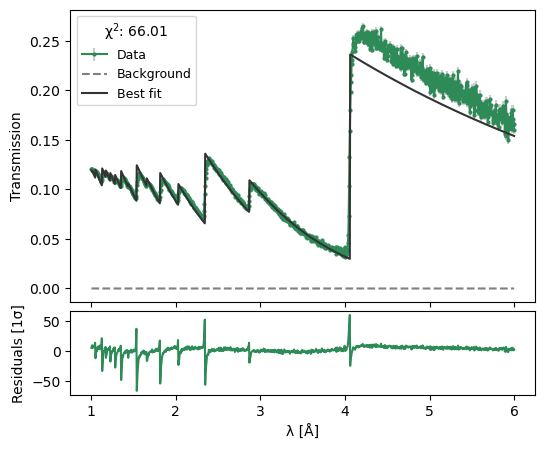

In [8]:
result.plot()


**Note**: This step is optional and included for comparison. The Rietveld method (next step) is often more stable for complex models.

---

## Step 7: Perform Rietveld-Style Staged Refinement

The Rietveld method refines parameters in stages, fitting subsets of parameters iteratively to improve stability and convergence. We define parameter groups to control which parameters are refined in each stage.

### Explanation
- **Parameter Groups**: We organize parameters into groups to refine sequentially:
  - `basic`: Normalization and thickness.
  - `bg`: Background parameters.
  - `extinction`: Extinction parameters.
  - `bg again and thickness`: Refine background and thickness together in the final stage.
- **Method**: Use `method="rietveld"` to enable staged refinement.
- **Progress Bar**: Set `progress_bar=True` to monitor the fitting progress.

### Code


In [9]:
groups = {
    "basic": ["norm", "thickness"],
    "bg": ["background"],
    "extinction": ["extinction"],
    "bg again and thickness": ["background", "thickness"]
}

result = model.fit(
    data,
    method="rietveld",
    param_groups=groups,
    progress_bar=True
)

Rietveld Fit:   0%|          | 0/4 [00:00<?, ?it/s]


**Expected Output**: A progress bar showing the reduced chi-squared for each stage, indicating the fit quality.

---

## Step 8: Inspect the Fitting Results


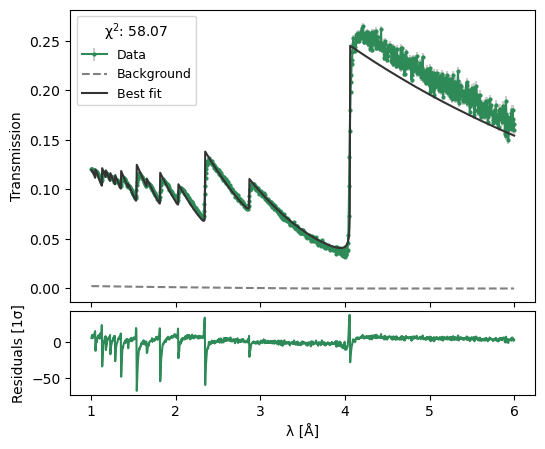

In [10]:
result.plot();

The `result` object contains the fit outcome, including parameter values and diagnostics. We can summarize the stages and visualize the results.

### Summarize Stages

In [11]:
result.stages_summary


**Expected Output**: A table showing parameter values and reduced chi-squared for each stage of the Rietveld refinement.

---

## Step 9: Visualize the Fit

Visualizations help assess the quality of the fit and understand how the model evolves during refinement.

### Plot Total Cross-Section at a Specific Stage


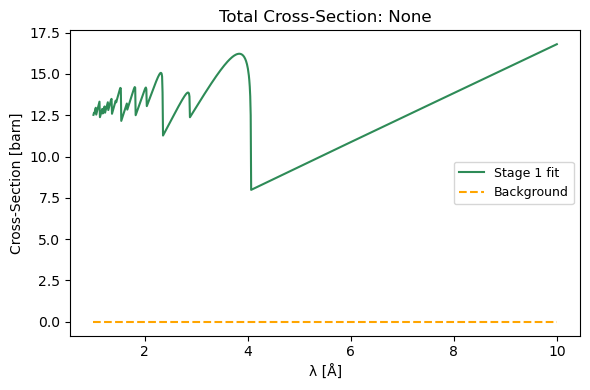

In [12]:
result.plot_total_xs(stage=1);


**Expected Output**: A plot comparing the modeled cross-section to the data at stage 1 of the refinement.

### Plot Stage Progression


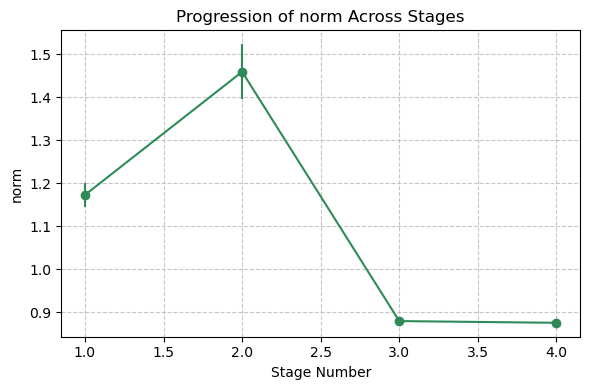

In [14]:
result.plot_stage_progression(param_name="norm");


**Expected Output**: A plot showing how the model fit improves across stages, with each stage refining different parameters.

### Plot Chi-Squared Progression


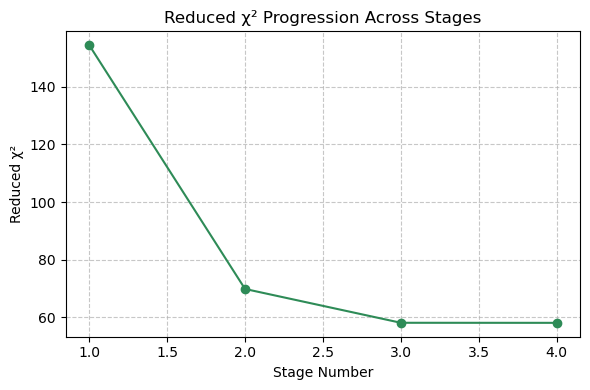

In [15]:
result.plot_chi2_progression();


**Expected Output**: A plot of the reduced chi-squared versus stage, showing the convergence of the fit.



# Parameter Groups Mini-Language for Rietveld-Style Staged Fitting

The Rietveld-style fitting method supports specifying parameter groups to refine in stages. This lets you control which parameters are fitted together at each stage to improve stability and interpretability.
Basics

    - You define a list or dictionary of groups, where each group corresponds to a stage.

    - Each group contains parameter names or predefined group keywords (like "basic", "background", "extinction", etc.).

    - The fitting process goes through each group sequentially, unfreezing only the parameters in that group and fitting them while keeping others fixed.

## Supported group formats

You can specify groups in one of three ways:

- List of lists:
- 
```python
param_groups = [
    ["norm", "thickness"],        # Stage 1: fit 'norm' and 'thickness'
    ["b0", "b1", "b2"],           # Stage 2: fit background params
    ["ext_l", "ext_Gg"]            # Stage 3: fit extinction parameters
]
```
- Dictionary of stage names to param lists:

```python
param_groups = {
    "Basic": ["norm", "thickness"],
    "Background": ["b0", "b1", "b2"],
    "Extinction": ["ext_l", "ext_Gg"]
}
```

- Mix of predefined group keywords and parameters:

```python
param_groups = {
    "Initial": ["basic"],
    "Background": ["background"],
    "Advanced": ["extinction", "orientation"]
}
```

Predefined group keywords are internally mapped to lists of parameter names (like "basic" maps to ["norm", "thickness"]).
Per-Stage Wavelength Range Overrides

You can also temporarily override the wavelength fitting range (wlmin and/or wlmax) for a specific stage by including strings in the group like:


- "wlmin=3"

- "wlmax=8"

For example:

```python
param_groups = {
    "Basic": ["basic"],
    "Background": ["background", "wlmin=3", "wlmax=8"],  # override wavelength range for this stage
    "Extinction": ["extinction"]
}
```

During the fitting of the "Background" stage, the fit will only consider data with wavelengths between 3 and 8 (overriding the global wlmin and wlmax arguments). After the stage, the original global wavelength limits are restored for the next stages.
What happens during fitting?

At each stage:

- Parameters not in the current group are fixed (not varied).

- Parameters in the group are unfrozen and fitted.

- If wlmin or wlmax overrides are specified in the group, the fit uses those for the data selection.

- The stage fit result is saved, including parameter values and reduced chi-squared.

- After all stages, a summary table is available showing the progression of parameter values, uncertainties, and goodness of fit.

## Example Usage
```python
param_groups = {
    "Norm & Thick": ["norm", "thickness"],
    "Background": ["b0", "b1", "wlmin=3", "wlmax=7"],
    "Extinction": ["ext_l", "ext_Gg"]
}

result = model.fit(
    data_df,
    method="rietveld",
    param_groups=param_groups,
    progress_bar=True
)

print(result.stages_summary)
```
This will fit:

    Stage 1: "norm" and "thickness" with default wavelength range.

    Stage 2: background parameters "b0" and "b1" using wavelengths from 3 to 7.

    Stage 3: extinction parameters with default wavelength range.